# Creación del script de pronóstico de energía para los parques eólicos Eurus, Bii-Hioxio y Eoliatec

## Importación de las bibliotecas

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from openpyxl import load_workbook

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Importación del dataset para obtener las observaciones

In [2]:
df_Prueba = pd.read_csv('./Datasets/Nizanda_22_Prueba.csv')
df_Prueba

Day  Month  Year  Hour  Barometer  Temp C  High Temp C  Low Temp C  \
0       1      1  2022     0      758.9    25.4         25.6        25.3   
1       1      1  2022     1      758.7    25.0         25.4        25.0   
2       1      1  2022     2      758.2    24.5         25.1        24.5   
3       1      1  2022     3      757.9    23.8         24.5        23.8   
4       1      1  2022     4      758.0    23.8         23.9        23.7   
...   ...    ...   ...   ...        ...     ...          ...         ...   
8755   31     12  2022    19      759.2    28.7         29.6        28.7   
8756   31     12  2022    20      759.6    28.3         28.8        28.3   
8757   31     12  2022    21      760.1    27.7         28.3        27.7   
8758   31     12  2022    22      760.5    27.2         27.8        27.2   
8759   31     12  2022    23      760.5    26.8         27.2        26.7   

      Hum %  Dew Point C  ...  Wind Run High Wind Speed m/s  \
0      88.0         23.3  ...      1.79                 5.4   
1      89.0         23.1  ...      1.79                 4.9   
2      89.0         22.6  ...      1.34                 4.5   
3      92.0         22.5  ...      0.89                 4.0   
4      91.0         22.2  ...      0.89                 4.5   
...     ...          ...  ...       ...                 ...   
8755   61.0         20.5  ...      2.24                 8.5   
8756   63.0         20.6  ...      1.79                 7.6   
8757   67.0         21.0  ...      1.79                 6.7   
8758   73.0         21.9  ...      2.24                 8.5   
8759   76.0         22.2  ...      2.24                 7.6   

      High Wind Direction  Wind Chill C Heat Index C  THW Index C  Rain mm  \
0                       S          25.4         27.6         27.6      0.0   
1                       S          25.0         27.0         27.0      0.0   
2                     SSE          24.5         26.2         26.2      0.0   
3                     SSW          23.8         25.4         25.4      0.0   
4                     SSE          23.8         25.3         25.3      0.0   
...                   ...           ...          ...          ...      ...   
8755                    W          28.7         30.7         30.7      0.0   
8756                  ENE          28.3         30.3         30.3      0.0   
8757                   NW          27.7         29.9         29.9      0.0   
8758                   NE          27.2         29.7         29.7      0.0   
8759                    N          26.8         29.3         29.3      0.0   

      Rain Rate mm/h  ET mm                 Date  
0                0.0   0.03  2022-01-01 00:00:00  
1                0.0   0.03  2022-01-01 01:00:00  
2                0.0   0.03  2022-01-01 02:00:00  
3                0.0   0.03  2022-01-01 03:00:00  
4                0.0   0.00  2022-01-01 04:00:00  
...              ...    ...                  ...  
8755             0.0   0.08  2022-12-31 19:00:00  
8756             0.0   0.08  2022-12-31 20:00:00  
8757             0.0   0.08  2022-12-31 21:00:00  
8758             0.0   0.05  2022-12-31 22:00:00  
8759             0.0   0.05  2022-12-31 23:00:00  

[8760 rows x 22 columns]

## Funciones a utilizar

In [3]:
def previous_date(current_date, frmt='%Y-%m-%d-%H', days = 1, string=True):
    yesterday = current_date - timedelta(days)
    if string:
        return yesterday.strftime(frmt), current_date.strftime(frmt)
    return yesterday

In [4]:
def get_dates(data, month, day, d = 1):
    current_date = datetime(2022, month, day)
    
    prev, current = previous_date(current_date, days = d + 1, string = True)
    month = data[(data['Date'] > prev) & (data['Date'] < current)]
    
    previous_days = month.iloc[:-24]
    current_day = month.iloc[len(previous_days):]
    
    return month, previous_days, current_day

In [5]:
def pronostico(Month, Day, model_type):
    obs = 0
    if(model_type == 'M-SVR'):
        obs = 2
    elif(model_type == 'LR'):
        obs = 4
    
    month, p, c = get_dates(df_Prueba, Month, Day, d = obs)

    drop_cols = [col for col in p.columns if col not in ['High Wind Speed m/s']]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    win = p
    
    # MULTIPLE OUTPUT
    win_scl = scaler.transform(win)
    win_scl = win_scl.reshape(1, -1)
    pred = model.predict(win_scl)
        
    ### PARA SINGLE INPUT
    # se realiza la transformacion inversa del scaler para los datos de las predicciones
    p_inv = scaler.inverse_transform(pred)
        
    p_inv = p_inv.flatten()
    
    return p_inv

In [6]:
def pronostico_LSTM(Month, Day):

    month, p, c = get_dates(df_Prueba, Month, Day, d = 4)
    drop_cols = [col for col in p.columns if col not in ['Month', 'Day', 'Hour', 'High Wind Speed m/s']]
    p.drop(drop_cols, axis = 1, inplace = True)
    
    x_input = p.values
    x_input_s = scaler.transform(x_input)
    x_input_s = x_input_s.flatten()
    
    x_input_s = x_input_s.reshape(1, 96, 4)
    pred = model.predict(x_input_s, verbose=0)
    
    return pred.flatten()
    

## Experimentación del script

In [7]:
# NECESARIO PARA CARGAR EL MODELO
import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, params = None):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None
        
        if params != None:
            self.C = params['C'][0]
            self.epsilon = params['epsilon'][0]
            self.gamma = params['gamma'][0]
            self.kernel = params['kernel'][0]
        #print(str(self.C))

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

In [8]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

### Utilizando M-SVR

In [ ]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_istmo.pkl', 'rb'))
scaler = pickle.load(open('scaler_istmo.pkl', 'rb'))
model_type = 'M-SVR'

### Utilizando Regresión Lineal

In [ ]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_LR.pkl', 'rb'))
scaler = pickle.load(open('scaler_LR.pkl', 'rb'))
model_type = 'LR'

### Pronóstico con M-SVR o LR (demostración)

In [ ]:
resultado = pronostico(5, 1, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento

### Utilizando LSTM

In [ ]:
## Cargando el modelo y el scaler
#model = pickle.load(open('model_LSTM.pkl', 'rb'))
model = keras.models.load_model('model_LSTM.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})
scaler = pickle.load(open('scaler_LSTM.pkl', 'rb'))
model_type = 'LSTM'

# Realizando la prediccion de la velocidad del viento
#resultado = pronostico(5, 3, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
scl_inv = MinMaxScaler()
scl_inv.min_, scl_inv.scale_ = scaler.min_[3], scaler.scale_[3]

resultado = pronostico_LSTM(5, 3)
resultado = scl_inv.inverse_transform(resultado.reshape(-1, 1))
resultado =  resultado.flatten()

### Días solicitados

In [10]:
## Cargando el modelo y el scaler
model = pickle.load(open('model_istmo.pkl', 'rb'))
scaler = pickle.load(open('scaler_istmo.pkl', 'rb'))
model_type = 'M-SVR'

In [11]:
## Arreglos de la velocidad del viento a energia de los parques eolicos: requerido para realizar la conversion viento-energia
E_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.5,25]
E_energia_mwh = [0,0,0,0,5.112,9.94,15.478,22.294,29.962,38.056,47.996,60.634,79.804,89.744,105.932,121.978,139.302,156.2,174.234,192.126,205.9,213,213,213,213,213,213,213,213,213,213,213,213,213,213,0,0,0,0,0]

B_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.4,25]
B_energia_mwh = [0,0,0,2.106,3.159,6.084,9.009,14.391,19.89,28.197,36.504,49.959,63.414,83.655,103.896,124.956,146.133,166.608,187.2,204.75,222.417,230.49,234,234,234,234,234,234,234,234,234,234,229.32,221.13,208.962,196.794,182.403,168.012,151.632,135.252]

Eo_v_m_s = [0,1,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,10.5,11,11.5,12,13,14,15,16,17,18,19,20,21,21.5,22,22.5,23,23.5,24,24.5,25]
Eo_energia_mwh = [0,0,0,0,0.7,1.42,2.62,3.82,5.66,7.48,9.38,11.3,14.4,17.52,21.34,25.14,29.66,34.18,38.8,43.02,45.2,46.9,48.4,49.2,49.8,50,50,50,50,50,50,50,50,50,50,50,50,0,0,0]

#### 15 Enero

In [12]:
# pronostico
resultado = pronostico(1, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 1, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Enero' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Enero' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

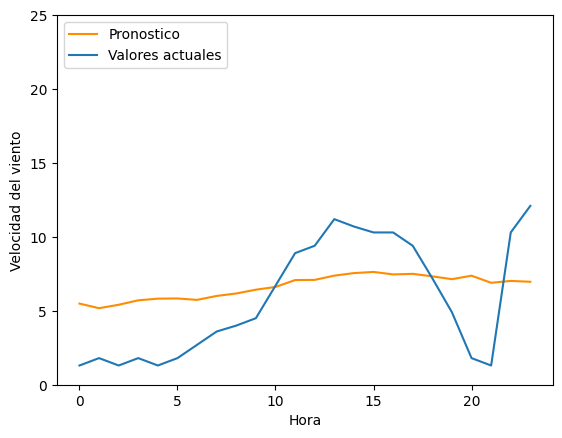

In [13]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Enero' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

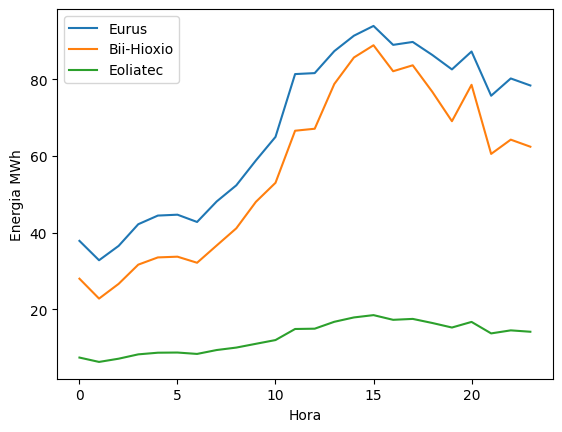

In [14]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Enero' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Abril

In [15]:
# pronostico
resultado = pronostico(4, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 4, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Abril' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Abril' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

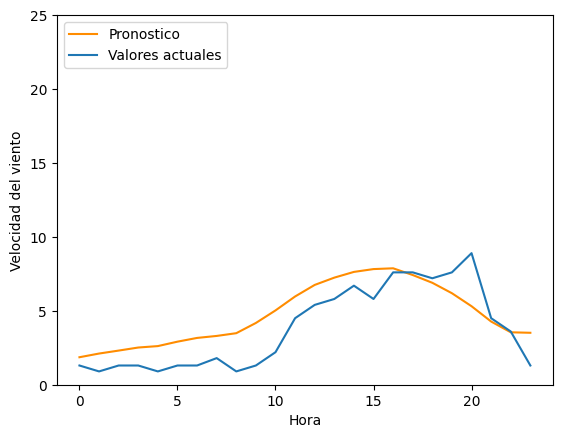

In [16]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Abril' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

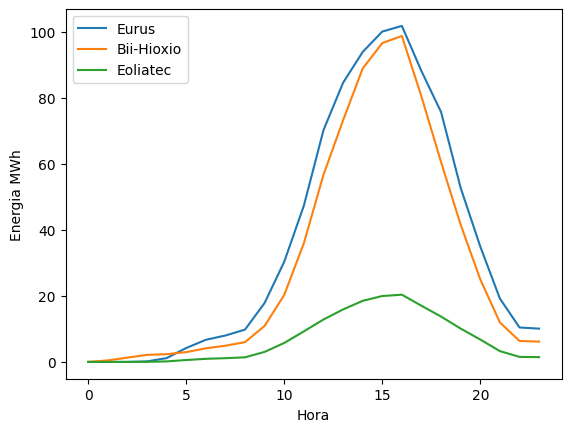

In [17]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Abril' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Junio

In [18]:
# pronostico
resultado = pronostico(6, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento
m, p, c = get_dates(df_Prueba, 6, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Junio' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Junio' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

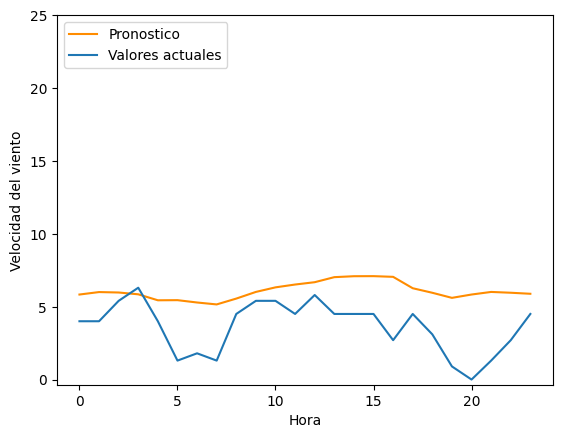

In [19]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Junio' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

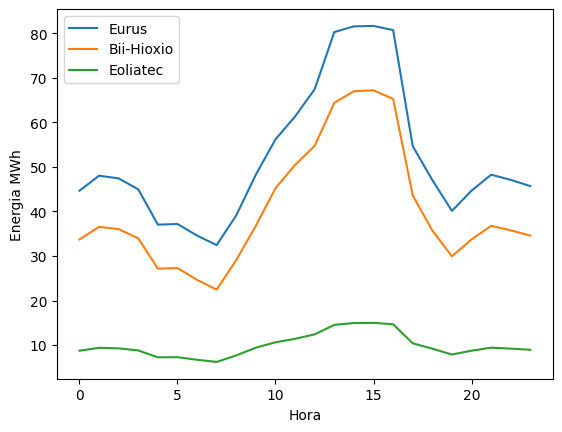

In [20]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Junio' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

#### 15 Octubre

In [21]:
# pronostico
resultado = pronostico(10, 15, model_type) # Mes, Dia: Devuelve la prediccion de la velocidad del viento

m, p, c = get_dates(df_Prueba, 10, 15, d = 2)

c_scaler = np.reshape(c['High Wind Speed m/s'].values, (-1, 1))
r_scaler = np.reshape(resultado, (-1, 1))
c_scaler = scaler.transform(c_scaler)
r_scaler = scaler.transform(r_scaler)

rmse_s = mean_squared_error(c_scaler.flatten(), r_scaler.flatten(), squared= False)
mae_s = mean_absolute_error(c_scaler.flatten(), r_scaler.flatten())

rmse = mean_squared_error(c['High Wind Speed m/s'].values, resultado, squared= False)
mae = mean_absolute_error(c['High Wind Speed m/s'].values, resultado)

Eurus_energia = np.interp(resultado, E_v_m_s, E_energia_mwh)
Bii_energia = np.interp(resultado, B_v_m_s, B_energia_mwh)
Eoliatec_energia = np.interp(resultado, Eo_v_m_s, Eo_energia_mwh)
    
# Creacion de un dataframe para juntar los 3 pronosticos
res_matriz = {'Eurus': Eurus_energia, 'Bii-Hioxio': Bii_energia, 'Eoliatec': Eoliatec_energia}
df_matriz = pd.DataFrame(res_matriz)
    
# Exporatacion a formato excel
df_matriz.to_excel('./Excel/generacion_energia_' + 'Octubre' + '_' + str(15) + '.xlsx', sheet_name='Dia ' + str(15))

# Colocar metricas RMSE y MAE
archivo = './Excel/generacion_energia_' + 'Octubre' + '_' + str(15) + '.xlsx'
workbook = load_workbook(filename=archivo)
lib = workbook["Dia 15"]

val_rmse_s = 'RMSE normalizado: ' + str(rmse_s)
val_mae_s = 'MAE normalizado: ' + str(mae_s)
val_rmse = 'RMSE: ' + str(rmse)
val_mae = 'MAE: ' + str(mae)

lib.cell(row = 1, column = 5).value = val_rmse_s
lib.cell(row = 2, column = 5).value = val_mae_s
lib.cell(row = 1, column = 6).value = val_rmse
lib.cell(row = 2, column = 6).value = val_mae

#save the file
workbook.save(filename=archivo)

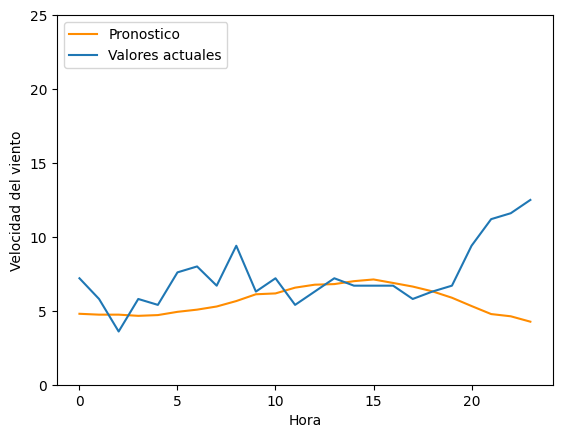

In [22]:
plt.plot(resultado, label = 'Pronostico', c = 'darkorange')
plt.plot(c['High Wind Speed m/s'].values, label = 'Valores actuales')
plt.xlabel('Hora')
plt.ylabel('Velocidad del viento')
plt.legend(loc = 'upper left')
plt.yticks(np.arange(0, 30, 5))
plt.savefig('./Excel/pronostico_viento_' + 'Octubre' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()

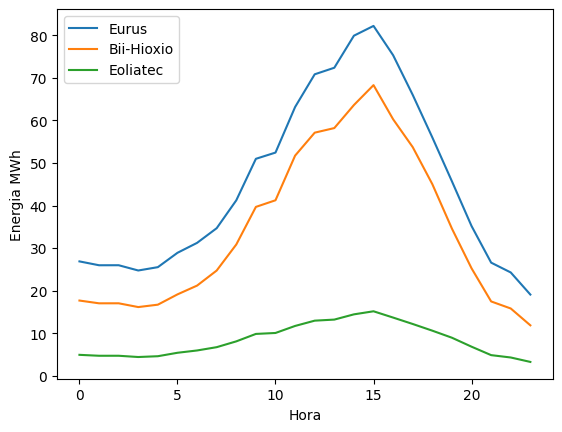

In [23]:
plt.plot(df_matriz['Eurus'], label = 'Eurus')
plt.plot(df_matriz['Bii-Hioxio'], label = 'Bii-Hioxio')
plt.plot(df_matriz['Eoliatec'], label = 'Eoliatec')
plt.xlabel('Hora')
plt.ylabel('Energia MWh')
plt.legend(loc = 'upper left')
plt.savefig('./Excel/pronostico_energia_' + 'Octubre' + '_' + str(15), transparent=True, bbox_inches = 'tight')
plt.show()